# Welcome to the Edith Project!
This project focuses on developing a context-based chatbot where users provide a context and can ask questions about it. The chatbot is trained using the SQuAD1.1 dataset, which provides a rich set of question-answering examples. In this notebook, we fine-tune a BERT model to adapt it to our specific task. Throughout the notebook, we will provide clear explanations for each step of the code, ensuring that readers can easily follow along and understand how the model is being prepared, trained, and evaluated. By the end, you’ll see how everything comes together to build a powerful question-answering system.

## Sections:
### 1. Data Preparation
In this section, we will preprocess the SQuAD1.1 dataset, convert it into the right format, and tokenize the input text using BERT's tokenizer. The goal is to prepare our data efficiently for model training.

### 2. Model Selection
We will select the BERT model as the backbone of our chatbot and explain why this pre-trained transformer model is suitable for question-answering tasks. We’ll also load the pre-trained model and tokenizer to kick-start the fine-tuning process.

### 3. Fine-Tuning and Training
Here, we’ll describe how we fine-tune the BERT model for our question-answering task, covering details such as learning rates, batch sizes, and optimization steps. We will also monitor key metrics like loss and F1 score during training to gauge performance.

### 4. Evaluation and Inference
After training, we will evaluate the model using various metrics like Exact Match (EM) and F1 score. We’ll also demonstrate how the chatbot handles inference, where the user provides a context, and the chatbot returns the most relevant answer.

### 5. Conclusion
In this final section, we’ll summarize the outcomes of the project, highlighting key performance metrics and possible improvements for future iterations of the Edith Project.


In [ ]:
!pip install -q torch transformers datasets tqdm scikit-learn rouge-score nltk datasets

import re
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForQuestionAnswering, get_scheduler
from tqdm import tqdm
import os
from sklearn.metrics import f1_score, precision_score, recall_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from IPython.display import display, HTML
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.ndimage import gaussian_filter1d

warnings.filterwarnings("ignore")


### 1. Data Preparation

In this section, we will load our data. The dataset we are using for this project is the well-known **SQuAD1.1** (Stanford Question Answering Dataset), developed by Stanford University. SQuAD1.1 has a wide range of applications in natural language understanding and question-answering tasks. This dataset is readily available on Hugging Face, and we can load it directly using the `datasets` library.

To avoid memory-related issues, we will only utilize the training dataset and split it into 95% for training and 5% for validation. The main reason for this split is that SQuAD1.1 contains approximately 87K samples, so even 5% (around 4.3K) provides a substantial number of examples for evaluation while ensuring the majority of data is used for training. This split ensures that our model has enough data to learn effectively while still being able to test its performance on a meaningful validation set.


In [ ]:
# Load SQuAD1.1 dataset
squad = load_dataset("squad")

train_data = squad["train"]

# Split the dataset into 95:5 ratio
train_test_split = train_data.train_test_split(test_size=0.05, seed=42)

train_data = train_test_split['train']
val_data = train_test_split['test']

# Check the sizes
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Train set size: 83219
Validation set size: 4380


In [ ]:
# Create an empty list to hold the rows
train_rows = []

# Iterate over the training data and collect relevant fields
for data in train_data:
    # For each answer in the list, create a new row
    for answer, start_index in zip(data['answers']['text'], data['answers']['answer_start']):
        # Calculate the end index of the answer
        end_index = start_index + len(answer) if start_index is not None else 0

        # Append a dictionary for each entry
        train_rows.append({
            'ID': data['id'],
            'Title': data['title'],
            'Context': data['context'],
            'Question': data['question'],
            'Answer': answer,
            'Answer Start Index': start_index if start_index is not None else 0,
            'Answer End Index': end_index if end_index is not None else 0
        })

# Convert the list of dictionaries into a DataFrame
train_df = pd.DataFrame(train_rows)

# Replace any missing values (NaN) in "Answer Start Index" or "Answer End Index" with 0
train_df['Answer Start Index'] = train_df['Answer Start Index'].fillna(0).astype(int)
train_df['Answer End Index'] = train_df['Answer End Index'].fillna(0).astype(int)

# Specify the columns to include in the DataFrame
train_df = train_df[['Context', 'Question', 'Answer', 'Answer Start Index', 'Answer End Index']]

# Display the first few rows
train_df.head()


Context  \
0  Starting in the 1890s and stretching in some p...   
1  Details of school casualties had been under no...   
2  Different religious traditions assign differin...   
3  The First Great Awakening was an evangelical a...   
4  Bacteria can be grown in the laboratory on nut...   

                                            Question  \
0  Which industries did European settlers in Alas...   
1         How many students were disabled in Xinhua?   
2  What are some religious traditions that are fo...   
3  What movement made a permanent mark on Protest...   
4  What are poultry eggs used for aside from cons...   

                                              Answer  Answer Start Index  \
0                                fishing and logging                 496   
1                                                546                 450   
2  expansive powers and abilities, psychological ...                 120   
3                          The First Great Awakening                   0   
4  Many vaccines to infectious diseases can be gr...                 120   

   Answer End Index  
0               515  
1               453  
2               233  
3                25  
4               197

In [ ]:
# Create an empty list to hold the rows
val_rows = []

# Iterate over the training data and collect relevant fields
for data in val_data:
    # For each answer in the list, create a new row
    for answer, start_index in zip(data['answers']['text'], data['answers']['answer_start']):
        # Calculate the end index of the answer
        end_index = start_index + len(answer) if start_index is not None else 0

        # Append a dictionary for each entry
        val_rows.append({
            'ID': data['id'],
            'Title': data['title'],
            'Context': data['context'],
            'Question': data['question'],
            'Answer': answer,
            'Answer Start Index': start_index if start_index is not None else 0,
            'Answer End Index': end_index if end_index is not None else 0
        })

# Convert the list of dictionaries into a DataFrame
val_df = pd.DataFrame(val_rows)

# Replace any missing values (NaN) in "Answer Start Index" or "Answer End Index" with 0
val_df['Answer Start Index'] = val_df['Answer Start Index'].fillna(0).astype(int)
val_df['Answer End Index'] = val_df['Answer End Index'].fillna(0).astype(int)

# Specify the columns to include in the DataFrame
val_df = val_df[['Context', 'Question', 'Answer', 'Answer Start Index', 'Answer End Index']]

# Display the first few rows
val_df.head()


Context  \
0  The Pew Forum on Religion & Public Life ranks ...   
1  The Ann Arbor Hands-On Museum is located in a ...   
2  One important aspect of the rule-of-law initia...   
3  In December 1547, Francis was in Malacca (Mala...   
4  Groups are also applied in many other mathemat...   

                                            Question         Answer  \
0  What percentage of Egyptians polled support de...            84%   
1         Ann Arbor ranks 1st among what goods sold?          books   
2  In developing countries, who makes most of the...  the executive   
3    Who impressed Xavier by taking notes in church?         Anjiro   
4  What represents elements of the fundamental gr...          loops   

   Answer Start Index  Answer End Index  
0                 468               471  
1                 402               407  
2                 612               625  
3                 160               166  
4                 489               494

In [ ]:
train_df.to_csv("squad_train.csv", index=False)
val_df.to_csv("squad_val.csv", index=False)


1. **Loading the SQuAD1.1 dataset**: The code begins by loading the SQuAD1.1 dataset using the `load_dataset` function from the `datasets` library. The training set (`train_data`) is then split into training and validation sets using an 95:5 ratio. This ensures that a portion of the original training data is reserved for validation purposes during model training.

2. **Initializing lists for storing data**: An empty list, `train_rows`, is created to store the processed rows of data from the training set. This will later be converted into a DataFrame for easier manipulation and saving.

3. **Processing training data**: The code iterates over each entry in the `train_data` split. For each entry, it extracts the ID, title, context, question, and answers from the dataset. For each answer, the corresponding start and end indices are calculated and stored in a dictionary.

4. **Converting training data to DataFrame**: Once all rows of the training data have been processed, they are converted into a pandas DataFrame. This allows for easier data manipulation, including replacing missing values and ensuring that the start and end indices are integers.

5. **Processing validation data**: The validation data undergoes the same process as the training data. The relevant fields (ID, title, context, question, and answers) are extracted, the start and end indices are calculated, and the data is stored in a list of dictionaries.

6. **Converting validation data to DataFrame**: Similar to the training data, the processed validation data is converted into a pandas DataFrame. Any missing values in the start and end indices are replaced with zeroes, and the columns are organized for consistency.

7. **Saving data to CSV**: Finally, the training and validation DataFrames are saved as CSV files (`squad_train.csv` and `squad_val.csv`). This makes it easy to load the preprocessed data for further analysis or model training.


In [ ]:
# Create a custom dataset class for our data
class SQuADataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        context = self.df.iloc[idx]['Context']
        question = self.df.iloc[idx]['Question']
        answer = self.df.iloc[idx]['Answer']
        answer_start = self.df.iloc[idx]['Answer Start Index']

        encoding = self.tokenizer.encode_plus(
            context,
            question,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_offsets_mapping=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        offset_mapping = encoding['offset_mapping'].squeeze().tolist()

         # Initialize start and end positions of the answer
        start_position = 0
        end_position = 0

        # Find the token positions corresponding to the answer if it's not unanswerable
        if answer_start != -1:
            for idx, (start, end) in enumerate(offset_mapping):
                if start <= answer_start < end:
                    start_position = idx
                if start < answer_start + len(answer) <= end:
                    end_position = idx
                    break

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(),
            'start_positions': torch.tensor(start_position),
            'end_positions': torch.tensor(end_position)
        }


# Set up the tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Create the dataset and data loader
train_dataset = SQuADataset(train_df, tokenizer, max_len=256)
val_dataset = SQuADataset(val_df, tokenizer, max_len=256)

In [ ]:
train_dataset[0]

{'input_ids': tensor([  101,  3225,  1999,  1996, 13678,  1998, 10917,  1999,  2070,  3182,
          2000,  1996,  2220, 28088,  1010,  2751, 18545,  1999,  7397,  1998,
          1996,  3518, 19898,  3700,  2716,  5190,  1997, 11257,  1998,  7322,
          2000,  7397,  1012,  7397,  2001,  3985,  5100,  2004,  2019,  4114,
          3700,  1999,  4878,  1012,  7397,  1005,  1055,  3007,  1010,  2029,
          2018,  2042,  1999,  4133,  2912,  2127,  5518,  1010,  2001,  2333,
          2167,  2000,  2238,  4887,  1012,  2810,  1997,  1996,  7397,  3099,
          1005,  1055,  7330,  2211,  2008,  2168,  2095,  1012,  2647,  7489,
          2013,  5120,  1998,  4701,  2036,  3876,  1999,  4643,  7397,  1010,
          2073,  2027,  3133,  1996,  5645,  1998, 15899,  6088,  1012,   102,
          2029,  6088,  2106,  2647,  7322,  1999,  7397,  4088,  1029,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

1. **Creating a Custom Dataset Class**: This code defines a custom dataset class called `SQuADataset`, which is built on top of PyTorch's `Dataset` class. This class is specifically designed to handle data from the SQuAD dataset, making it easier to load and work with during model training. It takes a DataFrame with context, questions, and answers, along with a tokenizer and a maximum sequence length as its parameters.

2. **Implementing the `__len__` Method**: The `__len__` method is implemented to return the total number of samples in the DataFrame. This is important for the DataLoader to know how many items it can iterate over when creating batches.

3. **Implementing the `__getitem__` Method**: In the `__getitem__` method, we retrieve the data for a specific index. This includes extracting the context, question, answer, and the starting position of the answer from the DataFrame. This method is crucial because it enables the DataLoader to access each sample during training.

4. **Encoding Context and Question**: Here, the `tokenizer.encode_plus` function is used to convert the context and question into a format suitable for the BERT model. It generates input IDs, attention masks, and token type IDs, ensuring that the sequence length does not exceed the specified maximum. This encoding step is essential for preparing the text for the model.

5. **Extracting Offset Mappings**: The encoded data includes offset mappings, which help us locate where in the original text the tokens correspond. This is particularly useful for identifying the exact position of the answer within the context.

6. **Determining Answer Positions**: The code checks if the answer is unanswerable (indicated by `answer_start` being `-1`). If there is an answer, it uses the offset mappings to find the token positions that correspond to the answer in the context. These start and end positions will be used later for training the model.

7. **Returning Encoded Inputs**: The `__getitem__` method returns a dictionary that contains the encoded input IDs, attention masks, token type IDs, and the start and end positions of the answer as tensors. This format is ready for input into the BERT model, simplifying the training process.

8. **Setting Up the Tokenizer**: The code initializes a tokenizer using `BertTokenizerFast`, which is known for its speed and efficiency. This tokenizer will be used to prepare the context and questions in our dataset.

9. **Creating Dataset Instances**: Two instances of the `SQuADataset` class are created: one for the training data and another for validation. The maximum sequence length is set to 256 tokens, which is a common practice to ensure a balance between memory usage and performance.

10. **Setting Up Data Loaders**: Finally, the code sets up `DataLoader` instances for both the training and validation datasets. The training DataLoader shuffles the data to provide the model with a varied set of examples in each epoch, while the validation DataLoader maintains the order for evaluation. These DataLoaders make batch processing during training and evaluation efficient and straightforward.

Overall, this code lays the groundwork for preparing the SQuAD dataset for training a BERT model, ensuring that the input data is properly formatted and that the answer positions are accurately identified for effective question answering.


### 2. Model Selection

In this section, we are selecting the BERT model, which stands for **Bidirectional Encoder Representations from Transformers**. BERT was developed by Google and is one of the most powerful models for natural language understanding tasks. What sets BERT apart from previous models is its **bidirectional training of transformers**—meaning it looks at the entire context (both left and right) of a word in a sentence, rather than just reading text from left to right or right to left. This allows it to gain a much deeper understanding of the context in which a word appears.

BERT was pre-trained on a massive amount of text data, including Wikipedia and books, using two key tasks:
1. **Masked Language Modeling (MLM)**: Where random words in a sentence are masked, and the model learns to predict them based on the surrounding context. This allows BERT to capture relationships between words.
2. **Next Sentence Prediction (NSP)**: Where BERT learns to predict whether two sentences follow each other in the text, which helps the model grasp the relationships between different sentences.

For our task of **Question Answering**, we use `BertForQuestionAnswering`, a version of BERT that has been fine-tuned for answering questions given a context. The model takes both the context and question as input and predicts the start and end positions of the answer within the context. This makes BERT an excellent choice for our project, as its deep contextual understanding enables it to pinpoint the answer even when the relationship between the question and context is complex.

In this particular code block, the line `model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')` loads a pre-trained version of BERT specifically fine-tuned for the question-answering task. The `bert-base-uncased` version uses a vocabulary where all words are lowercased, which simplifies the task of dealing with different word cases in the input text.

Next, we move the model to the GPU using `model.to(device)`. This step ensures that if a GPU (CUDA) is available, the model will use it for faster computation, which is important for both training and inference. If no GPU is available, the model will default to the CPU, though it will be slower.

In summary, BERT is a great fit for our task because:
- Its bidirectional nature helps it understand the question and context deeply.
- It has already been fine-tuned for question-answering tasks, saving us the effort of training from scratch.
- It's robust and has been proven to perform well on tasks like SQuAD, which is the dataset we are using.

By leveraging BERT, we can expect strong performance on our question-answering task, allowing the model to identify precise answers within a given context.


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
model.to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

### 3. Fine-Tuning and Training

**Pre-Code Explanation**:
In this section, we define the function that will fine-tune the BERT model for our specific question-answering task. Fine-tuning a pre-trained model like BERT involves adjusting the weights of the model slightly to specialize it on a new dataset. We start by setting hyperparameters such as the number of epochs, the learning rate (`3e-5`), and the optimizer. In this case, we use the `AdamW` optimizer, which is a variation of Adam designed to work well with transformers like BERT by incorporating weight decay to reduce overfitting.

A **scheduler** is set up to adjust the learning rate gradually over the training process using the `get_scheduler` function, which linearly decays the learning rate as training progresses. This helps maintain model stability during training and prevents drastic fluctuations in the loss. The function accepts the training and validation datasets, performs training in epochs, and logs important statistics such as loss values to track the model's performance.


In [ ]:
# Define the training function
def train_model(model, training_data, validation_data, epochs=5, learning_rate=3e-5):
    loss_history = []  # Store loss values
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Set up the learning rate scheduler
    total_steps = epochs * len(training_data)
    scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    for ep in range(epochs):  # Loop through epochs
        model.train()
        epoch_train_loss = 0
        train_progress = tqdm(training_data, desc="Training")

        for step_idx, step_batch in enumerate(train_progress):
            step_batch = {key: value.to(device) for key, value in step_batch.items()}
            output = model(**step_batch)
            loss_value = output.loss
            epoch_train_loss += loss_value.item()
            loss_history.append(loss_value.item())

            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            scheduler.step()

            # Print the average loss for the last 100 batches
            if (step_idx + 1) % 100 == 0:
                avg_last_100 = sum(loss_history[-100:]) / len(loss_history[-100:])
                print(f"Avg loss for last 100 steps (step {step_idx + 1}): {avg_last_100}")

            # Update progress bar with the current loss
            train_progress.set_postfix({"loss": loss_value.item()})

        average_train_loss = epoch_train_loss / len(training_data)
        print(f"Average Training Loss for Epoch {ep + 1}: {average_train_loss}")


        model.eval()
        total_validation_loss = 0
        validation_progress = tqdm(validation_data, desc="Validation")

        for val_idx, val_batch in enumerate(validation_progress):
            val_batch = {key: value.to(device) for key, value in val_batch.items()}
            with torch.no_grad():
                output = model(**val_batch)
                val_loss = output.loss
                total_validation_loss += val_loss.item()

        average_validation_loss = total_validation_loss / len(validation_data)
        print(f"Average Validation Loss for Epoch {ep + 1}: {average_validation_loss}")


In [ ]:
train_model(model, train_loader, val_loader)

Training:   4%|▍         | 99/2601 [02:28<1:02:40,  1.50s/it, loss=1.93]

Avg loss for last 100 steps (step 100): 2.9181237602233887


Training:   8%|▊         | 199/2601 [04:58<1:00:01,  1.50s/it, loss=1.58]

Avg loss for last 100 steps (step 200): 1.843290798664093


Training:  11%|█▏        | 299/2601 [07:28<57:40,  1.50s/it, loss=1.44]  

Avg loss for last 100 steps (step 300): 1.6185305523872375


Training:  15%|█▌        | 399/2601 [09:58<55:06,  1.50s/it, loss=1.56] 

Avg loss for last 100 steps (step 400): 1.5289679777622223


Training:  19%|█▉        | 499/2601 [12:28<52:31,  1.50s/it, loss=1.72] 

Avg loss for last 100 steps (step 500): 1.447012750506401


Training:  23%|██▎       | 599/2601 [14:58<50:03,  1.50s/it, loss=1.71] 

Avg loss for last 100 steps (step 600): 1.3697541028261184


Training:  27%|██▋       | 699/2601 [17:28<47:32,  1.50s/it, loss=1.34] 

Avg loss for last 100 steps (step 700): 1.3844239920377732


Training:  31%|███       | 799/2601 [19:58<45:05,  1.50s/it, loss=1.19] 

Avg loss for last 100 steps (step 800): 1.2496907639503478


Training:  35%|███▍      | 899/2601 [22:28<42:47,  1.51s/it, loss=1.33] 

Avg loss for last 100 steps (step 900): 1.2965397924184798


Training:  38%|███▊      | 999/2601 [24:58<40:03,  1.50s/it, loss=1.28] 

Avg loss for last 100 steps (step 1000): 1.2438341867923737


Training:  42%|████▏     | 1099/2601 [27:28<37:34,  1.50s/it, loss=0.851]

Avg loss for last 100 steps (step 1100): 1.2373633629083634


Training:  46%|████▌     | 1199/2601 [29:58<35:01,  1.50s/it, loss=1.28] 

Avg loss for last 100 steps (step 1200): 1.1354780173301697


Training:  50%|████▉     | 1299/2601 [32:29<32:41,  1.51s/it, loss=1.13] 

Avg loss for last 100 steps (step 1300): 1.1638590478897095


Training:  54%|█████▍    | 1399/2601 [34:59<30:03,  1.50s/it, loss=0.963]

Avg loss for last 100 steps (step 1400): 1.1318764191865922


Training:  58%|█████▊    | 1499/2601 [37:29<27:33,  1.50s/it, loss=0.97] 

Avg loss for last 100 steps (step 1500): 1.1282511121034622


Training:  61%|██████▏   | 1599/2601 [39:59<25:03,  1.50s/it, loss=1.43] 

Avg loss for last 100 steps (step 1600): 1.1512188524007798


Training:  65%|██████▌   | 1699/2601 [42:29<22:34,  1.50s/it, loss=0.924]

Avg loss for last 100 steps (step 1700): 1.1037893587350844


Training:  69%|██████▉   | 1799/2601 [45:00<20:01,  1.50s/it, loss=1.37] 

Avg loss for last 100 steps (step 1800): 1.1223931908607483


Training:  73%|███████▎  | 1899/2601 [47:30<17:32,  1.50s/it, loss=1.22] 

Avg loss for last 100 steps (step 1900): 1.0834963840246201


Training:  77%|███████▋  | 1999/2601 [50:00<15:02,  1.50s/it, loss=1.3]  

Avg loss for last 100 steps (step 2000): 1.0893496036529542


Training:  81%|████████  | 2099/2601 [52:30<12:33,  1.50s/it, loss=0.894]

Avg loss for last 100 steps (step 2100): 1.0850343543291092


Training:  85%|████████▍ | 2199/2601 [55:00<10:04,  1.50s/it, loss=0.973]

Avg loss for last 100 steps (step 2200): 1.098406316637993


Training:  88%|████████▊ | 2299/2601 [57:30<07:33,  1.50s/it, loss=0.931]

Avg loss for last 100 steps (step 2300): 1.0876016092300416


Training:  92%|█████████▏| 2399/2601 [1:00:00<05:02,  1.50s/it, loss=1.54]

Avg loss for last 100 steps (step 2400): 1.0816582387685776


Training:  96%|█████████▌| 2499/2601 [1:02:30<02:33,  1.50s/it, loss=1.12] 

Avg loss for last 100 steps (step 2500): 1.0321623659133912


Training: 100%|█████████▉| 2599/2601 [1:05:00<00:03,  1.50s/it, loss=1.02] 

Avg loss for last 100 steps (step 2600): 1.0567743647098542


Training: 100%|██████████| 2601/2601 [1:05:03<00:00,  1.50s/it, loss=1.02] 


Average Training Loss for Epoch 1: 1.295620406077303


Validation: 100%|██████████| 137/137 [01:12<00:00,  1.90it/s]


Average Validation Loss for Epoch 1: 0.9500351820113885


Training:   4%|▍         | 99/2601 [02:28<1:02:41,  1.50s/it, loss=0.697]

Avg loss for last 100 steps (step 100): 0.8142830759286881


Training:   8%|▊         | 199/2601 [04:58<1:00:13,  1.50s/it, loss=0.865]

Avg loss for last 100 steps (step 200): 0.8329307380318641


Training:  11%|█▏        | 299/2601 [07:29<57:33,  1.50s/it, loss=1.08]   

Avg loss for last 100 steps (step 300): 0.7891313913464546


Training:  15%|█▌        | 399/2601 [09:59<55:04,  1.50s/it, loss=0.666]

Avg loss for last 100 steps (step 400): 0.7705841365456582


Training:  19%|█▉        | 499/2601 [12:29<52:39,  1.50s/it, loss=1.27] 

Avg loss for last 100 steps (step 500): 0.8177345561981201


Training:  23%|██▎       | 599/2601 [14:59<50:00,  1.50s/it, loss=1.09] 

Avg loss for last 100 steps (step 600): 0.8327104163169861


Training:  27%|██▋       | 699/2601 [17:29<47:32,  1.50s/it, loss=0.866]

Avg loss for last 100 steps (step 700): 0.810658627152443


Training:  31%|███       | 799/2601 [19:59<45:09,  1.50s/it, loss=0.88] 

Avg loss for last 100 steps (step 800): 0.8449877372384071


Training:  35%|███▍      | 899/2601 [22:30<42:32,  1.50s/it, loss=0.661]

Avg loss for last 100 steps (step 900): 0.8116492775082588


Training:  38%|███▊      | 999/2601 [25:00<40:05,  1.50s/it, loss=1.19] 

Avg loss for last 100 steps (step 1000): 0.8410855442285537


Training:  42%|████▏     | 1099/2601 [27:30<37:36,  1.50s/it, loss=1.02] 

Avg loss for last 100 steps (step 1100): 0.804014807343483


Training:  46%|████▌     | 1199/2601 [30:00<35:11,  1.51s/it, loss=0.962]

Avg loss for last 100 steps (step 1200): 0.8255293396115303


Training:  50%|████▉     | 1299/2601 [32:30<32:29,  1.50s/it, loss=0.837]

Avg loss for last 100 steps (step 1300): 0.8005913615226745


Training:  54%|█████▍    | 1399/2601 [35:00<30:02,  1.50s/it, loss=1.16] 

Avg loss for last 100 steps (step 1400): 0.7952284491062165


Training:  58%|█████▊    | 1499/2601 [37:30<27:38,  1.51s/it, loss=0.865]

Avg loss for last 100 steps (step 1500): 0.7911309421062469


Training:  61%|██████▏   | 1599/2601 [40:01<25:07,  1.50s/it, loss=0.47] 

Avg loss for last 100 steps (step 1600): 0.8090464314818382


Training:  65%|██████▌   | 1699/2601 [42:31<22:34,  1.50s/it, loss=0.98] 

Avg loss for last 100 steps (step 1700): 0.7942702674865723


Training:  69%|██████▉   | 1799/2601 [45:01<20:00,  1.50s/it, loss=0.549]

Avg loss for last 100 steps (step 1800): 0.7940633481740952


Training:  73%|███████▎  | 1899/2601 [47:31<17:36,  1.50s/it, loss=0.664]

Avg loss for last 100 steps (step 1900): 0.7622592401504517


Training:  77%|███████▋  | 1999/2601 [50:01<15:07,  1.51s/it, loss=0.791]

Avg loss for last 100 steps (step 2000): 0.8292095738649369


Training:  81%|████████  | 2099/2601 [52:32<12:34,  1.50s/it, loss=0.874]

Avg loss for last 100 steps (step 2100): 0.8038192576169968


Training:  85%|████████▍ | 2199/2601 [55:02<10:02,  1.50s/it, loss=0.98] 

Avg loss for last 100 steps (step 2200): 0.8064938718080521


Training:  88%|████████▊ | 2299/2601 [57:32<07:32,  1.50s/it, loss=1.25] 

Avg loss for last 100 steps (step 2300): 0.8164249670505523


Training:  92%|█████████▏| 2399/2601 [1:00:02<05:02,  1.50s/it, loss=1.06] 

Avg loss for last 100 steps (step 2400): 0.7864927875995636


Training:  96%|█████████▌| 2499/2601 [1:02:32<02:33,  1.50s/it, loss=0.497]

Avg loss for last 100 steps (step 2500): 0.8313259115815163


Training: 100%|█████████▉| 2599/2601 [1:05:02<00:02,  1.49s/it, loss=0.522]

Avg loss for last 100 steps (step 2600): 0.7982275319099427


Training: 100%|██████████| 2601/2601 [1:05:04<00:00,  1.50s/it, loss=0.727]


Average Training Loss for Epoch 2: 0.8081949698562945


Validation: 100%|██████████| 137/137 [01:12<00:00,  1.90it/s]


Average Validation Loss for Epoch 2: 0.9094252549383762


Training:   4%|▍         | 99/2601 [02:28<1:02:36,  1.50s/it, loss=0.409]

Avg loss for last 100 steps (step 100): 0.5861263217031956


Training:   8%|▊         | 199/2601 [04:59<1:00:14,  1.50s/it, loss=0.527]

Avg loss for last 100 steps (step 200): 0.5470401339232922


Training:  11%|█▏        | 299/2601 [07:29<57:43,  1.50s/it, loss=0.637]  

Avg loss for last 100 steps (step 300): 0.5824183216691017


Training:  15%|█▌        | 399/2601 [09:59<55:12,  1.50s/it, loss=0.592]

Avg loss for last 100 steps (step 400): 0.5499672368168831


Training:  19%|█▉        | 499/2601 [12:29<52:39,  1.50s/it, loss=0.695]

Avg loss for last 100 steps (step 500): 0.5772905349731445


Training:  23%|██▎       | 599/2601 [14:59<50:05,  1.50s/it, loss=1.13] 

Avg loss for last 100 steps (step 600): 0.5968974930047989


Training:  27%|██▋       | 699/2601 [17:29<47:28,  1.50s/it, loss=0.443]

Avg loss for last 100 steps (step 700): 0.5567461925745011


Training:  31%|███       | 799/2601 [19:59<45:03,  1.50s/it, loss=0.395]

Avg loss for last 100 steps (step 800): 0.5894309616088867


Training:  35%|███▍      | 899/2601 [22:29<42:34,  1.50s/it, loss=0.771]

Avg loss for last 100 steps (step 900): 0.5873063451051712


Training:  38%|███▊      | 999/2601 [24:59<40:05,  1.50s/it, loss=0.476]

Avg loss for last 100 steps (step 1000): 0.5972063279151917


Training:  42%|████▏     | 1099/2601 [27:29<37:30,  1.50s/it, loss=0.565]

Avg loss for last 100 steps (step 1100): 0.6006231245398521


Training:  46%|████▌     | 1199/2601 [29:59<35:02,  1.50s/it, loss=0.472]

Avg loss for last 100 steps (step 1200): 0.5915874150395394


Training:  50%|████▉     | 1299/2601 [32:29<32:33,  1.50s/it, loss=0.532]

Avg loss for last 100 steps (step 1300): 0.5902719554305077


Training:  54%|█████▍    | 1399/2601 [35:00<30:05,  1.50s/it, loss=0.443]

Avg loss for last 100 steps (step 1400): 0.580033713877201


Training:  58%|█████▊    | 1499/2601 [37:30<27:34,  1.50s/it, loss=0.808]

Avg loss for last 100 steps (step 1500): 0.5817161786556244


Training:  61%|██████▏   | 1599/2601 [40:00<25:03,  1.50s/it, loss=0.733]

Avg loss for last 100 steps (step 1600): 0.5787480530142785


Training:  65%|██████▌   | 1699/2601 [42:30<22:31,  1.50s/it, loss=0.44] 

Avg loss for last 100 steps (step 1700): 0.5743653793632985


Training:  69%|██████▉   | 1799/2601 [45:00<20:03,  1.50s/it, loss=0.373]

Avg loss for last 100 steps (step 1800): 0.5669003206491471


Training:  73%|███████▎  | 1899/2601 [47:30<17:35,  1.50s/it, loss=0.441]

Avg loss for last 100 steps (step 1900): 0.5621130636334419


Training:  77%|███████▋  | 1999/2601 [50:00<15:02,  1.50s/it, loss=0.396]

Avg loss for last 100 steps (step 2000): 0.592484669983387


Training:  81%|████████  | 2099/2601 [52:30<12:34,  1.50s/it, loss=0.507]

Avg loss for last 100 steps (step 2100): 0.5556239295005798


Training:  85%|████████▍ | 2199/2601 [55:00<10:04,  1.50s/it, loss=0.486]

Avg loss for last 100 steps (step 2200): 0.571899283528328


Training:  88%|████████▊ | 2299/2601 [57:31<07:35,  1.51s/it, loss=0.279]

Avg loss for last 100 steps (step 2300): 0.5776233053207398


Training:  92%|█████████▏| 2399/2601 [1:00:01<05:02,  1.50s/it, loss=0.65]

Avg loss for last 100 steps (step 2400): 0.5737731790542603


Training:  96%|█████████▌| 2499/2601 [1:02:31<02:32,  1.50s/it, loss=0.893]

Avg loss for last 100 steps (step 2500): 0.5883317263424397


Training: 100%|█████████▉| 2599/2601 [1:05:01<00:02,  1.50s/it, loss=0.677]

Avg loss for last 100 steps (step 2600): 0.575586271584034


Training: 100%|██████████| 2601/2601 [1:05:03<00:00,  1.50s/it, loss=0.634]


Average Training Loss for Epoch 3: 0.5781794790692716


Validation: 100%|██████████| 137/137 [01:12<00:00,  1.90it/s]


Average Validation Loss for Epoch 3: 0.999135330210637


Training:   4%|▍         | 99/2601 [02:28<1:02:43,  1.50s/it, loss=0.285]

Avg loss for last 100 steps (step 100): 0.413784771412611


Training:   8%|▊         | 199/2601 [04:59<1:00:03,  1.50s/it, loss=0.432]

Avg loss for last 100 steps (step 200): 0.43284411162137987


Training:  11%|█▏        | 299/2601 [07:29<57:39,  1.50s/it, loss=0.355]  

Avg loss for last 100 steps (step 300): 0.44033734187483786


Training:  15%|█▌        | 399/2601 [09:59<55:03,  1.50s/it, loss=0.457] 

Avg loss for last 100 steps (step 400): 0.4177935104072094


Training:  19%|█▉        | 499/2601 [12:29<52:36,  1.50s/it, loss=0.262]

Avg loss for last 100 steps (step 500): 0.42030997440218926


Training:  23%|██▎       | 599/2601 [14:59<50:10,  1.50s/it, loss=0.417]

Avg loss for last 100 steps (step 600): 0.43777878060936926


Training:  27%|██▋       | 699/2601 [17:29<47:39,  1.50s/it, loss=0.252]

Avg loss for last 100 steps (step 700): 0.44543042451143267


Training:  31%|███       | 799/2601 [19:59<45:02,  1.50s/it, loss=0.331]

Avg loss for last 100 steps (step 800): 0.41820422530174256


Training:  35%|███▍      | 899/2601 [22:29<42:16,  1.49s/it, loss=0.434]

Avg loss for last 100 steps (step 900): 0.4102541197836399


Training:  38%|███▊      | 999/2601 [24:59<40:03,  1.50s/it, loss=0.381]

Avg loss for last 100 steps (step 1000): 0.4401281327009201


Training:  42%|████▏     | 1099/2601 [27:29<37:33,  1.50s/it, loss=0.375]

Avg loss for last 100 steps (step 1100): 0.40734992161393163


Training:  46%|████▌     | 1199/2601 [29:59<35:01,  1.50s/it, loss=0.347]

Avg loss for last 100 steps (step 1200): 0.4229107615351677


Training:  50%|████▉     | 1299/2601 [32:30<32:35,  1.50s/it, loss=0.596]

Avg loss for last 100 steps (step 1300): 0.4366910111904144


Training:  54%|█████▍    | 1399/2601 [35:00<30:02,  1.50s/it, loss=0.514]

Avg loss for last 100 steps (step 1400): 0.41040504559874535


Training:  58%|█████▊    | 1499/2601 [37:30<27:33,  1.50s/it, loss=0.321]

Avg loss for last 100 steps (step 1500): 0.41208766609430314


Training:  61%|██████▏   | 1599/2601 [40:00<25:02,  1.50s/it, loss=0.362]

Avg loss for last 100 steps (step 1600): 0.4288914044201374


Training:  65%|██████▌   | 1699/2601 [42:30<22:39,  1.51s/it, loss=0.348]

Avg loss for last 100 steps (step 1700): 0.4072799864411354


Training:  69%|██████▉   | 1799/2601 [45:00<20:03,  1.50s/it, loss=0.18] 

Avg loss for last 100 steps (step 1800): 0.40538637042045594


Training:  73%|███████▎  | 1899/2601 [47:30<17:32,  1.50s/it, loss=0.394]

Avg loss for last 100 steps (step 1900): 0.41915873721241953


Training:  77%|███████▋  | 1999/2601 [50:00<15:00,  1.50s/it, loss=0.36] 

Avg loss for last 100 steps (step 2000): 0.42285729214549067


Training:  81%|████████  | 2099/2601 [52:30<12:32,  1.50s/it, loss=0.45] 

Avg loss for last 100 steps (step 2100): 0.3937626303732395


Training:  85%|████████▍ | 2199/2601 [55:00<10:03,  1.50s/it, loss=0.365]

Avg loss for last 100 steps (step 2200): 0.4223772123456001


Training:  88%|████████▊ | 2299/2601 [57:30<07:33,  1.50s/it, loss=0.447]

Avg loss for last 100 steps (step 2300): 0.4191547580063343


Training:  92%|█████████▏| 2399/2601 [1:00:00<05:03,  1.50s/it, loss=0.423]

Avg loss for last 100 steps (step 2400): 0.4223488415777683


Training:  96%|█████████▌| 2499/2601 [1:02:30<02:33,  1.50s/it, loss=0.597]

Avg loss for last 100 steps (step 2500): 0.4321207369863987


Training: 100%|█████████▉| 2599/2601 [1:05:00<00:02,  1.50s/it, loss=0.288]

Avg loss for last 100 steps (step 2600): 0.4203851442039013


Training: 100%|██████████| 2601/2601 [1:05:03<00:00,  1.50s/it, loss=0.632]


Average Training Loss for Epoch 4: 0.4216204704870769


Validation: 100%|██████████| 137/137 [01:12<00:00,  1.90it/s]


Average Validation Loss for Epoch 4: 1.0965224147713097


Training:   4%|▍         | 99/2601 [02:28<1:02:26,  1.50s/it, loss=0.324] 

Avg loss for last 100 steps (step 100): 0.31893704675137996


Training:   8%|▊         | 199/2601 [04:58<1:00:02,  1.50s/it, loss=0.446]

Avg loss for last 100 steps (step 200): 0.30915156394243243


Training:  11%|█▏        | 299/2601 [07:28<57:27,  1.50s/it, loss=0.232]  

Avg loss for last 100 steps (step 300): 0.32221948117017746


Training:  15%|█▌        | 399/2601 [09:58<54:44,  1.49s/it, loss=0.185]

Avg loss for last 100 steps (step 400): 0.32024823017418386


Training:  19%|█▉        | 499/2601 [12:28<52:28,  1.50s/it, loss=0.563]

Avg loss for last 100 steps (step 500): 0.3506594298779964


Training:  23%|██▎       | 599/2601 [14:57<49:54,  1.50s/it, loss=0.215] 

Avg loss for last 100 steps (step 600): 0.3250641016662121


Training:  27%|██▋       | 699/2601 [17:27<47:40,  1.50s/it, loss=0.338]

Avg loss for last 100 steps (step 700): 0.3352129091322422


Training:  31%|███       | 799/2601 [19:57<45:01,  1.50s/it, loss=0.209]

Avg loss for last 100 steps (step 800): 0.3395147521793842


Training:  35%|███▍      | 899/2601 [22:27<42:32,  1.50s/it, loss=0.423]

Avg loss for last 100 steps (step 900): 0.3108686701953411


Training:  38%|███▊      | 999/2601 [24:57<39:59,  1.50s/it, loss=0.362]

Avg loss for last 100 steps (step 1000): 0.355789770334959


Training:  42%|████▏     | 1099/2601 [27:26<37:32,  1.50s/it, loss=0.39]  

Avg loss for last 100 steps (step 1100): 0.3256390055269003


Training:  46%|████▌     | 1199/2601 [29:56<35:05,  1.50s/it, loss=0.194]

Avg loss for last 100 steps (step 1200): 0.32589283064007757


Training:  50%|████▉     | 1299/2601 [32:26<32:32,  1.50s/it, loss=0.374] 

Avg loss for last 100 steps (step 1300): 0.3462872489541769


Training:  54%|█████▍    | 1399/2601 [34:56<30:08,  1.50s/it, loss=0.299]

Avg loss for last 100 steps (step 1400): 0.3290054628252983


Training:  58%|█████▊    | 1499/2601 [37:26<27:36,  1.50s/it, loss=0.216]

Avg loss for last 100 steps (step 1500): 0.30920374870300293


Training:  61%|██████▏   | 1599/2601 [39:56<25:04,  1.50s/it, loss=0.364]

Avg loss for last 100 steps (step 1600): 0.31953610375523567


Training:  65%|██████▌   | 1699/2601 [42:26<22:35,  1.50s/it, loss=0.185]

Avg loss for last 100 steps (step 1700): 0.3104771442711353


Training:  69%|██████▉   | 1799/2601 [44:57<20:05,  1.50s/it, loss=0.263]

Avg loss for last 100 steps (step 1800): 0.3241106171905994


Training:  73%|███████▎  | 1899/2601 [47:27<17:31,  1.50s/it, loss=0.191]

Avg loss for last 100 steps (step 1900): 0.3105654291808605


Training:  77%|███████▋  | 1999/2601 [49:57<15:02,  1.50s/it, loss=0.279] 

Avg loss for last 100 steps (step 2000): 0.33756139226257803


Training:  81%|████████  | 2099/2601 [52:27<12:27,  1.49s/it, loss=0.388] 

Avg loss for last 100 steps (step 2100): 0.33014354825019837


Training:  85%|████████▍ | 2199/2601 [54:56<10:02,  1.50s/it, loss=0.302] 

Avg loss for last 100 steps (step 2200): 0.3082833808660507


Training:  88%|████████▊ | 2299/2601 [57:26<07:32,  1.50s/it, loss=0.19] 

Avg loss for last 100 steps (step 2300): 0.321821516752243


Training:  92%|█████████▏| 2399/2601 [59:56<05:02,  1.50s/it, loss=0.294] 

Avg loss for last 100 steps (step 2400): 0.32693059600889685


Training:  96%|█████████▌| 2499/2601 [1:02:26<02:32,  1.50s/it, loss=0.188]

Avg loss for last 100 steps (step 2500): 0.3449856662750244


Training: 100%|█████████▉| 2599/2601 [1:04:56<00:02,  1.50s/it, loss=0.201] 

Avg loss for last 100 steps (step 2600): 0.3208476223796606


Training: 100%|██████████| 2601/2601 [1:04:58<00:00,  1.50s/it, loss=0.647]


Average Training Loss for Epoch 5: 0.3262371334495429


Validation: 100%|██████████| 137/137 [01:12<00:00,  1.90it/s]

Average Validation Loss for Epoch 5: 1.1965753805898403


#### Saving model

In [ ]:
# Define the directory where you want to save the model
model_save_path = 'squad-bert-trained/BERT_model'

# Create the directory if it doesn't exist
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)


# Save the trained model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('squad-bert-trained/BERT_model/tokenizer_config.json',
 'squad-bert-trained/BERT_model/special_tokens_map.json',
 'squad-bert-trained/BERT_model/vocab.txt',
 'squad-bert-trained/BERT_model/added_tokens.json',
 'squad-bert-trained/BERT_model/tokenizer.json')

#### Creating a .zip folder to load in local system

In [ ]:
# Compress the model directory into a zip file
!zip -r model.zip squad-bert-trained/BERT_model

# Download the zip file to your local system
from IPython.display import FileLink

# Display a link to download the file
FileLink(r'model.zip')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: squad-bert-trained/BERT_model/ (stored 0%)
  adding: squad-bert-trained/BERT_model/tokenizer_config.json (deflated 76%)
  adding: squad-bert-trained/BERT_model/model.safetensors (deflated 7%)
  adding: squad-bert-trained/BERT_model/config.json (deflated 47%)
  adding: squad-bert-trained/BERT_model/special_tokens_map.json (deflated 42%)
  adding: squad-bert-trained/BERT_model/tokenizer.json (deflated 71%)
  adding: squad-bert-trained/BERT_model/vocab.txt (deflated 53%)


/kaggle/working/model.zip

#### Loading the model and setting it to evaluation model

In [ ]:
# Load the saved model and tokenizer
model_save_path = 'squad-bert-trained/BERT_model'
model = BertForQuestionAnswering.from_pretrained(model_save_path)
tokenizer = BertTokenizerFast.from_pretrained(model_save_path)

print(f"Moving the model to {device}\n\n")
model.to(device)

# Set the model to evaluation mode
model.eval()

Moving the model to cuda




BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

**Post-Code Explanation**:
The core of the training process is handled within the loop, where the model’s parameters are iteratively updated based on the training data and loss function.

- **Gradient Updates**:
  - At the beginning of each batch iteration, `optimizer.zero_grad()` clears out the gradients from the previous iteration. This is essential because PyTorch accumulates gradients, and not clearing them would result in incorrect gradient updates.
  - `loss_value.backward()` performs backpropagation, calculating the gradients for the current batch of data with respect to the loss. The gradients are stored in the model's parameters.
  - `optimizer.step()` updates the model's weights using the gradients computed during backpropagation, adjusting the model to minimize the loss.

- **Learning Rate Scheduling**:
  - After each batch, the learning rate scheduler (`scheduler.step()`, if included) is triggered, adjusting the learning rate dynamically based on predefined rules (such as decay). This helps in ensuring steady convergence and avoiding overshooting the optimal weights.

- **Loss Tracking**:
  - Throughout the training process, we monitor the loss at regular intervals (e.g., every 100 batches). This involves keeping track of batch losses and printing the average, which gives us an indication of how well the model is learning over time. This step is crucial for diagnosing issues such as vanishing gradients or exploding losses early in the training process.

- **Validation Phase**:
  - Once an epoch is completed, the model switches to evaluation mode using `model.eval()`. This phase disables dropout and batch normalization layers, which are only active during training. Additionally, `torch.no_grad()` ensures that no gradients are calculated during validation, which reduces computational overhead and memory usage.
  - During validation, the model's performance is assessed on unseen validation data by computing the validation loss. This serves as a proxy for how well the model generalizes to data outside the training set.

- **Epoch Summary**:
  - At the end of each epoch, both training and validation losses are printed. These metrics are critical in diagnosing potential overfitting (training loss drops while validation loss increases) or underfitting (both losses remain high). If overfitting is detected, strategies such as early stopping or regularization might be applied in subsequent training runs.

- **Fine-tuning**:
  - Monitoring these metrics allows us to decide if further fine-tuning is necessary. Fine-tuning might include adjustments in learning rate, model architecture, batch size, or the number of epochs. This step helps ensure the model is trained effectively while avoiding problems like overfitting or underfitting.


### 4. Evaluation and Inference

After completing the training phase and saving the model in the previous section, we now move on to the evaluation and inference process. This section is critical in determining how well the model performs on unseen data, and it provides insights into the model's generalization capabilities.

- **Inference**:
  - To begin, we will load the saved model checkpoint and run a few sample inputs through it to observe its predictions. This allows us to visually assess how well the model handles the task, whether it's generating coherent responses or correctly answering questions. Running individual examples also helps in detecting any obvious issues, such as grammatical errors, incompleteness, or irrelevant outputs.
  - We’ll also compare the model's predictions against the ground truth to evaluate its performance qualitatively.

- **Evaluation Using Metrics**:
  - After running some basic examples, we will systematically evaluate the model using standard metrics for language models. In this project, we are using **ROUGE**, **BLEU**, and **F1** scores, which are commonly used for evaluating the quality of text generation tasks such as question answering, summarization, or machine translation.
    - **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**: This metric measures the overlap between the generated text and the reference text. ROUGE-1 measures the overlap of unigrams, ROUGE-2 for bigrams, and ROUGE-L for the longest common subsequence. It is especially useful for tasks like summarization, where capturing important words and phrases is critical.
    - **BLEU (Bilingual Evaluation Understudy)**: BLEU measures the precision of n-grams between the generated and reference texts, primarily focusing on fluency and syntactic quality. It is widely used for translation tasks.
    - **F1 Accuracy**: This metric evaluates the balance between precision and recall, focusing on how well the model's answers match the reference answers. It is especially important for tasks like question answering, where both exact matches and partially correct answers are considered.
  
- **Automated Evaluation**:
  - We will loop through the test dataset and generate predictions for each input. For every prediction, we will calculate the ROUGE, BLEU, and F1 scores. These metrics will give us a quantitative evaluation of the model’s performance across the entire test set.
  - By averaging these scores, we will determine the overall performance of the model. A higher average score in all metrics indicates that the model has learned to generate meaningful, accurate, and fluent responses.

- **Analysis of Results**:
  - Once the evaluation is complete, we will analyze the results. If the scores indicate that the model performs well (e.g., high ROUGE and BLEU scores), it means that the model has effectively learned the task and can generalize to unseen data. On the other hand, if the evaluation scores are low, it may be a sign that the model is either underfitting or overfitting.
  - In case of suboptimal performance, further fine-tuning of the model or hyperparameters may be required, or additional training data might be necessary to improve the results.

- **Next Steps**:
  - Based on the evaluation results, we might consider improvements, such as adjusting the training process, refining the model’s architecture, or experimenting with data augmentation techniques. Evaluating the error cases in detail will guide future decisions to enhance the model’s overall performance.


In [ ]:
def answer_question(question, context):
    max_context_size = 512
    chunk_size = max_context_size

    chunks = [context[i:i+chunk_size] for i in range(0, len(context), chunk_size)]

    answers = []
    for chunk in chunks:
        # Tokenize the chunk
        inputs = tokenizer(chunk, question, return_tensors='pt', truncation=True, max_length=max_context_size).to(device)

        # Generate the output
        with torch.no_grad():
            outputs = model(**inputs)

            # Get most likely beginning and end of the answer span
            answer_start_scores = outputs.start_logits
            answer_end_scores = outputs.end_logits

            # Find the tokens with the highest `start` and `end` scores
            answer_start = torch.argmax(answer_start_scores)
            answer_end = torch.argmax(answer_end_scores) + 1

            # Convert the tokens to text
            answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

            answers.append(answer)

    # Combine the answers from each chunk
    answer = ' '.join(answers)
    answer = answer.replace('[CLS]', '')
    return answer.strip()

In [ ]:
context = """On March 30, 2015, it was announced that Beyoncé is a co-owner, with various other music artists, in the music streaming service Tidal. The service specialises in lossless audio and high
definition music videos. Beyoncé's husband Jay Z acquired the parent company of Tidal, Aspiro, in the first quarter of 2015. Including Beyoncé and Jay-Z, sixteen artist stakeholders
(such as Kanye West, Rihanna, Madonna, Chris Martin, Nicki Minaj and more) co-own Tidal, with the majority owning a 3% equity stake. The idea of having an all artist owned streaming
service was created by those involved to adapt to the increased demand for streaming within the current music industry, and to rival other streaming services such as Spotify, which have
been criticised for their low payout of royalties. "The challenge is to get everyone to respect music again, to recognize its value", stated Jay-Z on the release of Tidal."""

questions = [
    "When was it discovered Beyonce was a co-owner of the music service, Tidal",
    "The parent company of Tidal became under the ownership of whom in 2015?",
    "What kind of service is Tidal?",

]

# True Answers for validation (if needed)
True_Answers = ["September 1876", "twice", "The Observer", "three", "1987"]

# Assuming you have a function called answer_question that returns answers based on the context and question.
# Here we would loop through questions and print the results in the specified format.

for index, question in enumerate(questions, start=1):
    answer = answer_question(question, context)
    print(f"Q{index}: {question}")
    print(f"A{index}: {answer}")
    print()


Q1: When was it discovered Beyonce was a co-owner of the music service, Tidal
A1: march 30, 2015 jay - z on the release of tidal.

Q2: The parent company of Tidal became under the ownership of whom in 2015?
A2: jay z spotify

Q3: What kind of service is Tidal?
A3: music streaming all artist owned



In [ ]:
# Test with a new question and context
context = """
Music is an art form whose medium is sound and silence. It is a universal language that
can evoke emotions, convey messages, and bring people together. Music has been an
integral part of human culture for centuries, with various genres and styles emerging
across the world. From classical to contemporary, music has the power to inspire, heal,
and entertain.
"""
question = "What is the difference between Music and Harmony?"

# Get the answer from the model
answer = answer_question(question, context)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What is the difference between Music and Harmony?
Answer: it is a universal language that can evoke emotions, convey messages, and bring people together. music has been an integral part of human culture for centuries, with various genres and styles emerging across the world. from classical to contemporary, music has the power to inspire, heal, and entertain


In [ ]:
context = """
Space robotics is a field of robotics that focuses on the design, development, and operation of robots that can
survive and function in the harsh environment of space. These robots are designed to perform a variety of tasks,
such as space exploration, satellite maintenance, and planetary surface operations.
Space robots can be autonomous or remotely controlled, and they often require specialized
systems to withstand the extreme temperatures, radiation, and vacuum of space.

Space robotics has many applications, including:

Planetary exploration: Robots like NASA's Curiosity Rover and Perseverance Rover
have been used to explore the surface of Mars and gather data about the planet's geology and climate.
Satellite maintenance: Robots like the Canadarm2 robotic arm on the
International Space Station have been used to perform maintenance tasks and repairs on satellites in orbit.
Asteroid mining: Robots are being developed to explore and mine asteroids
for valuable resources like water and precious metals.
"""

question = "What are the applications of Space Robotics?"

# Get the answer from the model
answer = answer_question(question, context)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What are the applications of Space Robotics?
Answer: space exploration, satellite maintenance, and planetary surface operations


In [ ]:

# Define your function for calculating metrics and generating answers
def calculate_metrics(val_df):
    metrics = {
        'rouge1': [],
        'rouge2': [],
        'rougel': [],
        'bleu': [],
        'f1': []  # Add F1 score to metrics
    }

    # Initialize the scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Initialize lists to store answers and predicted answers
    answers = []
    predicted_answers = []

    # Iterate over the predictions
    for question_id in range(val_df.shape[0]):
        predicted_answer = answer_question(val_df.iloc[question_id]['Question'], val_df.iloc[question_id]['Context']).lower().strip()
        answer = val_df.iloc[question_id]['Answer'].lower().strip()

        # Store the answers and predicted answers
        answers.append(answer)
        predicted_answers.append(predicted_answer)

        # Calculate ROUGE scores
        rouge_scores = scorer.score(answer, predicted_answer)
        metrics['rouge1'].append(rouge_scores['rouge1'].fmeasure)
        metrics['rouge2'].append(rouge_scores['rouge2'].fmeasure)
        metrics['rougel'].append(rouge_scores['rougeL'].fmeasure)

        # Calculate BLEU score
        metrics['bleu'].append(sentence_bleu([answer.split()], predicted_answer.split(), weights=(1.0, 0.0, 0.0, 0.0)))

        # Calculate F1 score
        # Use a basic precision and recall approach based on the ROUGE scores
        precision = rouge_scores['rouge1'].precision
        recall = rouge_scores['rouge1'].recall
        if precision + recall > 0:  # Avoid division by zero
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0
        metrics['f1'].append(f1)

    return metrics, answers, predicted_answers




In [ ]:
# Import Gaussian filter for smoothing
from scipy.ndimage import gaussian_filter1d

warnings.filterwarnings("ignore")

# Calculate metrics
metrics, answers, predicted_answers = calculate_metrics(val_df)

# Calculate average scores
average_metrics = {key: sum(value) / len(value) for key, value in metrics.items()}

# Print the average metrics
print('Average ROUGE-1:', average_metrics['rouge1'])
print('Average ROUGE-2:', average_metrics['rouge2'])
print('Average ROUGE-L:', average_metrics['rougel'])
print('Average BLEU:', average_metrics['bleu'])
print('Average F1 Score:', average_metrics['f1'])  # Print the average F1 score

# Calculate the lengths of answers
actual_lengths = [len(answer) for answer in answers]
predicted_lengths = [len(predicted_answer) for predicted_answer in predicted_answers]

# Create a DataFrame for easier plotting
import pandas as pd

lengths_df = pd.DataFrame({
    'Index': range(len(actual_lengths)),
    'Actual Lengths': actual_lengths,
    'Predicted Lengths': predicted_lengths
})



Average ROUGE-1: 0.5453534984095015
Average ROUGE-2: 0.3224320844012193
Average ROUGE-L: 0.5431188724586591
Average BLEU: 0.39141109481540254
Average F1 Score: 0.5453534984095015


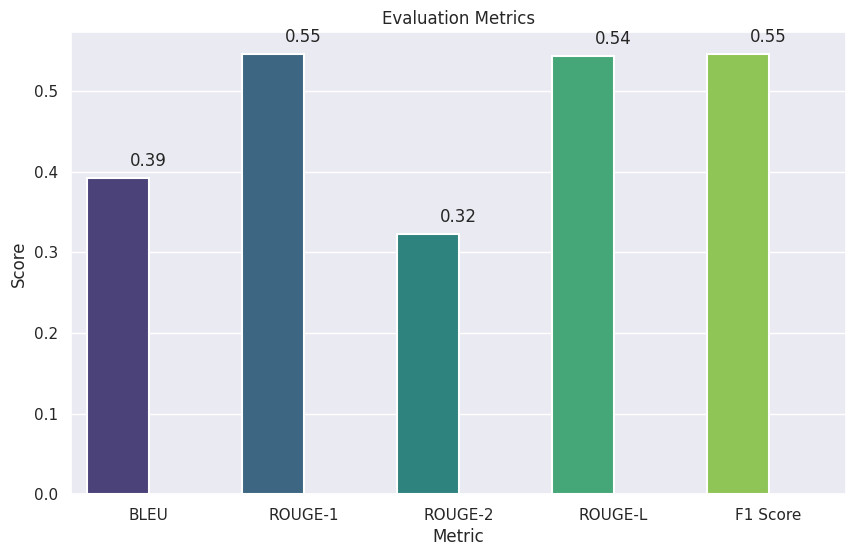

In [ ]:
# Scores and labels
scores = [
    average_metrics['bleu'],
    average_metrics['rouge1'],
    average_metrics['rouge2'],
    average_metrics['rougel'],
    average_metrics['f1']
]
labels = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'F1 Score']

# Set the style for seaborn
sns.set(style="darkgrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=labels, y=scores, palette= 'viridis', linewidth=1.5)

# Set the width of the bars
for bar in bar_plot.patches:
    bar.set_width(0.4)  # Set the width of the bars

# Adding scores on top of each bar
for index, value in enumerate(scores):
    bar_plot.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Adding title and labels
plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')

# Display the plot
plt.show()


Average ROUGE-1: 0.5453534984095015
Average ROUGE-2: 0.3224320844012193
Average ROUGE-L: 0.5431188724586591
Average BLEU: 0.39141109481540254
Average F1 Score: 0.5453534984095015


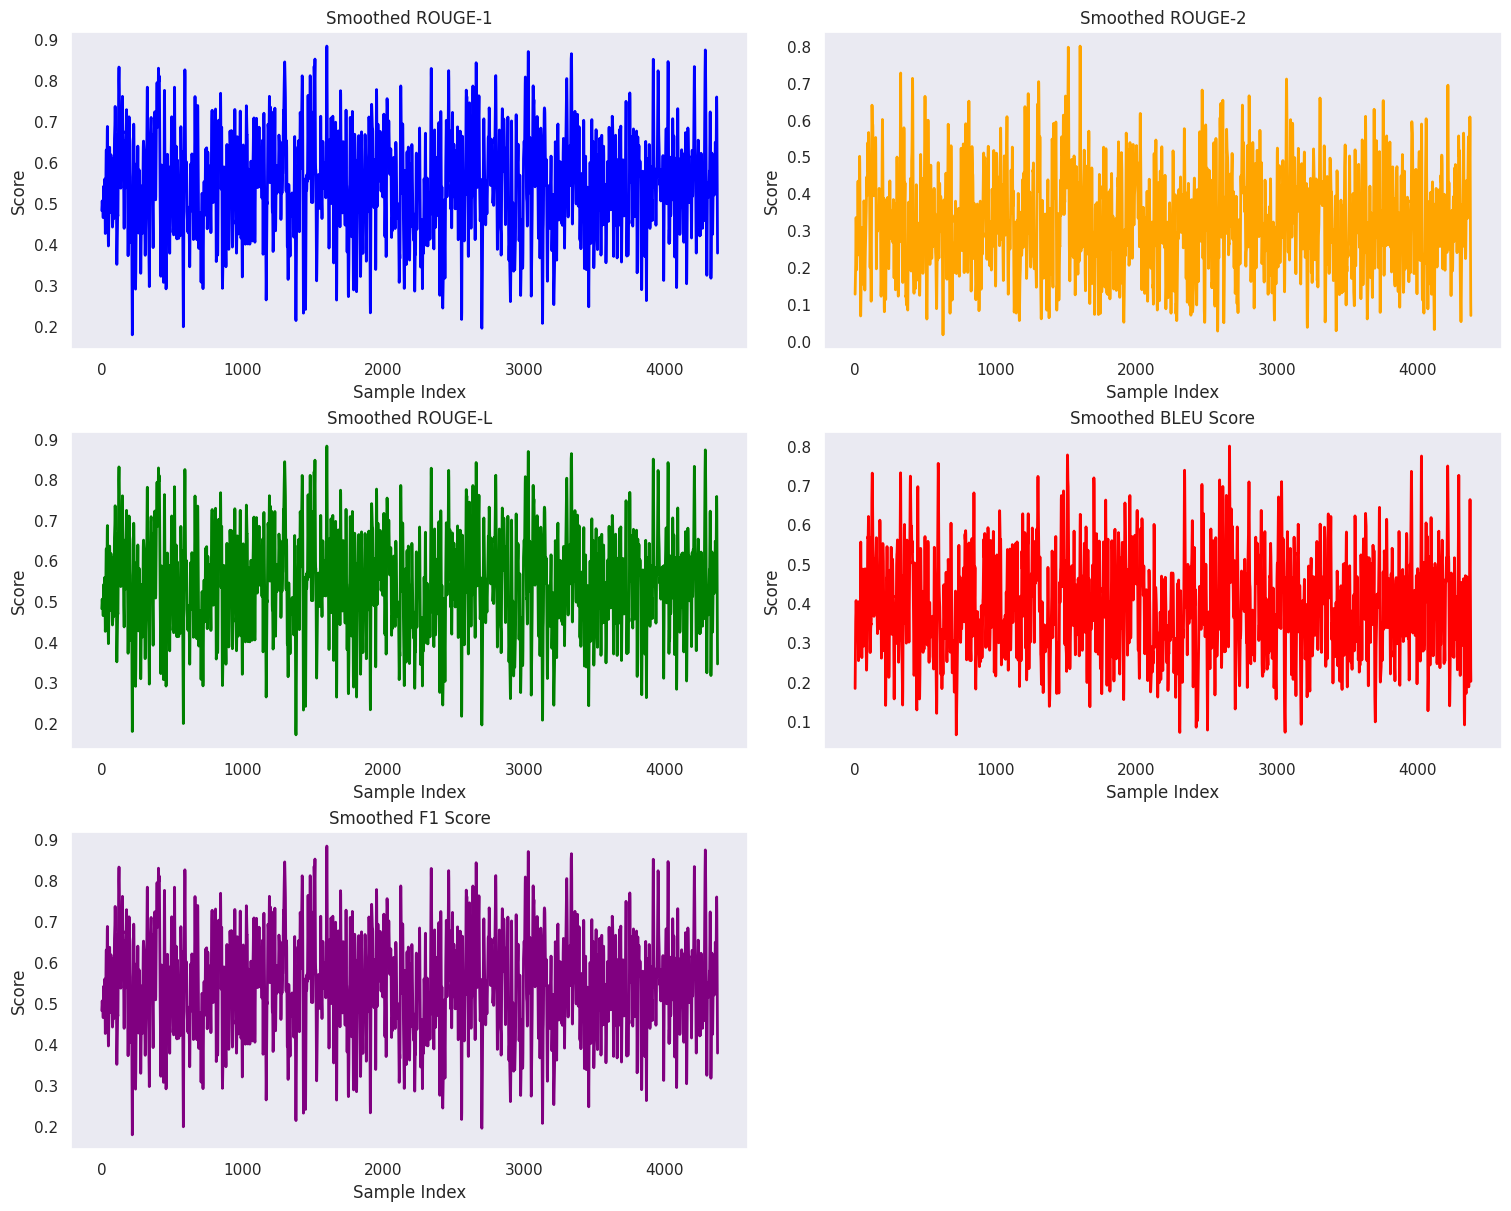

In [ ]:
# Print the average metrics
print('Average ROUGE-1:', average_metrics['rouge1'])
print('Average ROUGE-2:', average_metrics['rouge2'])
print('Average ROUGE-L:', average_metrics['rougel'])
print('Average BLEU:', average_metrics['bleu'])
print('Average F1 Score:', average_metrics['f1'])  # Print the average F1 score

# Prepare the DataFrame for plotting
metrics_df = pd.DataFrame({
    'Index': range(len(metrics['rouge1'])),  # Assuming all metrics have the same length
    'ROUGE-1': metrics['rouge1'],
    'ROUGE-2': metrics['rouge2'],
    'ROUGE-L': metrics['rougel'],
    'BLEU': metrics['bleu'],
    'F1 Score': metrics['f1']
})

# Smooth the metrics using a Gaussian filter
smoothed_metrics_df = pd.DataFrame({
    'Index': metrics_df['Index'],
    'ROUGE-1': gaussian_filter1d(metrics_df['ROUGE-1'], sigma=2),
    'ROUGE-2': gaussian_filter1d(metrics_df['ROUGE-2'], sigma=2),
    'ROUGE-L': gaussian_filter1d(metrics_df['ROUGE-L'], sigma=2),
    'BLEU': gaussian_filter1d(metrics_df['BLEU'], sigma=2),
    'F1 Score': gaussian_filter1d(metrics_df['F1 Score'], sigma=2)
})

# Set the style for seaborn
sns.set(style="darkgrid")

# Create subplots for each metric
fig, axs = plt.subplots(3, 2, figsize=(15, 12), constrained_layout=True)

# Plot each metric
axs[0, 0].plot(smoothed_metrics_df['Index'], smoothed_metrics_df['ROUGE-1'], color='blue', linewidth=2)
axs[0, 0].set_title('Smoothed ROUGE-1')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Score')
axs[0, 0].grid()

axs[0, 1].plot(smoothed_metrics_df['Index'], smoothed_metrics_df['ROUGE-2'], color='orange', linewidth=2)
axs[0, 1].set_title('Smoothed ROUGE-2')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Score')
axs[0, 1].grid()

axs[1, 0].plot(smoothed_metrics_df['Index'], smoothed_metrics_df['ROUGE-L'], color='green', linewidth=2)
axs[1, 0].set_title('Smoothed ROUGE-L')
axs[1, 0].set_xlabel('Sample Index')
axs[1, 0].set_ylabel('Score')
axs[1, 0].grid()

axs[1, 1].plot(smoothed_metrics_df['Index'], smoothed_metrics_df['BLEU'], color='red', linewidth=2)
axs[1, 1].set_title('Smoothed BLEU Score')
axs[1, 1].set_xlabel('Sample Index')
axs[1, 1].set_ylabel('Score')
axs[1, 1].grid()

axs[2, 0].plot(smoothed_metrics_df['Index'], smoothed_metrics_df['F1 Score'], color='purple', linewidth=2)
axs[2, 0].set_title('Smoothed F1 Score')
axs[2, 0].set_xlabel('Sample Index')
axs[2, 0].set_ylabel('Score')
axs[2, 0].grid()

# Remove the empty subplot
fig.delaxes(axs[2, 1])

# Show the plots
plt.show()


This code defines a system for evaluating question-answering models based on various metrics, such as ROUGE, BLEU, and F1 score. The `calculate_metrics` function processes a dataset of questions, contexts, and answers to generate predicted answers using a pre-trained model. It computes ROUGE-1, ROUGE-2, ROUGE-L, and BLEU scores for each prediction, as well as an F1 score using precision and recall from the ROUGE-1 score.

The code also smooths the metric values using a Gaussian filter, which helps to visualize trends more clearly. It plots the smoothed ROUGE-1, ROUGE-2, ROUGE-L, BLEU, and F1 scores in subplots to track the model's performance across different samples. The final metrics and smoothed visualizations provide insights into how well the model answers questions relative to the ground truth, helping to assess its accuracy and effectiveness in the task.

This code evaluates the performance of a question-answering model using various metrics to assess its accuracy and effectiveness. It includes two primary functions: `calculate_metrics` and a visualization section.

1. **`calculate_metrics(val_df)`**:
   - This function takes a validation DataFrame (`val_df`) containing questions, contexts, and true answers.
   - It initializes a dictionary to store ROUGE-1, ROUGE-2, ROUGE-L, BLEU, and F1 scores.
   - Using the `RougeScorer`, it computes the ROUGE scores for each predicted answer against the true answer. For each entry, it:
     - Calls the `answer_question` function to generate a predicted answer.
     - Appends the computed ROUGE scores, BLEU score (based on the predicted and true answers), and F1 score (calculated using precision and recall from ROUGE-1) to the metrics dictionary.
   - The function returns the complete metrics, along with lists of true answers and predicted answers.

2. **Metric Calculation and Averaging**:
   - After calculating metrics for all questions, the code computes the average values for ROUGE-1, ROUGE-2, ROUGE-L, BLEU, and F1 score to provide an overall assessment of the model's performance.

3. **Length Calculation**:
   - The code calculates the lengths of the actual and predicted answers, storing these lengths in lists for further analysis.

4. **Visualization**:
   - It prepares a DataFrame (`lengths_df`) to facilitate plotting the lengths of actual and predicted answers.
   - Finally, it creates a separate DataFrame (`metrics_df`) for visualizing the individual metric scores over different samples, applying a Gaussian filter to smooth the results.
   - The code generates subplots for each metric (ROUGE-1, ROUGE-2, ROUGE-L, BLEU, and F1 score), allowing for a visual assessment of the model's performance trends.

Overall, this evaluation framework enables an in-depth analysis of how well the question-answering model performs across various metrics, providing insights into its strengths and weaknesses.



### Inference on Model Evaluation Results

The evaluation metrics we’ve gathered shed light on how well our question-answering model is performing, especially when it comes to understanding context and generating responses. Here’s a closer look at what these numbers mean and how they might impact real-world business applications:

1. **Average ROUGE-1: 0.545**:
   - This metric measures how many of the individual words in the model's answers overlap with those in the reference answers. A score of 0.545 indicates a decent level of agreement.
   - **Implication**: For businesses, this suggests that our model can pick up key information quite well. Imagine a customer support chatbot that can understand and respond to common inquiries accurately—that’s what this score implies. Customers would likely receive relevant answers to their questions, improving their experience.

2. **Average ROUGE-2: 0.322**:
   - ROUGE-2 looks at pairs of consecutive words. A score of 0.322 indicates that the model struggles a bit more here.
   - **Implication**: This tells us that while our model is good at picking out individual words, it sometimes misses the mark when it comes to understanding phrases or context. In a business setting, this could impact things like product descriptions or service explanations, where precise language is essential for clarity and customer understanding.

3. **Average ROUGE-L: 0.543**:
   - This metric considers the longest common subsequence of words in the answers. A score of 0.543 suggests the model maintains a fair amount of coherence in its responses.
   - **Implication**: This is important for user engagement. Think about virtual assistants that need to provide detailed answers—this score indicates that the model can create responses that flow reasonably well, making it easier for users to follow along.

4. **Average BLEU: 0.391**:
   - BLEU measures how well the generated answers match the expected responses, focusing on precision. An average score of 0.391 indicates that while the answers are relevant, they may not always capture the full context perfectly.
   - **Implication**: In practical terms, this could affect applications like content generation or translation. Businesses might find that while the model can generate helpful content, there’s still room for improvement. This could mean more editing or refining to ensure the final product meets quality standards.

5. **Average F1 Score: 0.545**:
   - The F1 score balances precision (how many of the returned answers were correct) and recall (how many correct answers were returned). A score of 0.545 suggests moderate performance.
   - **Implication**: For businesses, this score indicates that the model is fairly good at providing accurate responses without overwhelming users with incorrect information. This balance is particularly important in sensitive fields like healthcare or finance, where getting things right can make a big difference.

### Real-World Business Applications
- **Context-Based Customer Support**: These metrics suggest that the model could be effectively integrated into customer service platforms, automating responses to frequently asked questions based on context. This could enhance user satisfaction and reduce response times.

- **Contextual Content Generation**: The model shows promise for generating contextually relevant content for blogs, reports, and marketing materials. While it performs decently, human review will be essential to align the generated content with the brand's voice and ensure it resonates with the target audience.

- **Contextual Data Analysis**: Teams could leverage the model to summarize findings or generate insights from reports, enhancing productivity and allowing decision-makers to focus on crucial information without getting bogged down in details.

- **Advanced Chatbots and Virtual Assistants**: The results suggest that while the model can provide useful context-based answers, further fine-tuning is needed to fully grasp user intent and context. Improving this aspect could significantly enhance user interactions, making them feel more natural and intuitive.

In summary, these evaluation metrics indicate that our model has a solid foundation for context-based question answering but also highlight opportunities for enhancement. As we continue to refine its capabilities, we’re paving the way for more effective tools that can genuinely benefit businesses and their customers.


In [2]:
pwd

'C:\\Users\\mohds\\OneDrive - University of San Diego\\Desktop\\MS_AAI\\Natural Language Processing and GenAI (AAI-520-A1)\\EDITH_ChatBOT'